In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.7 MB/s eta 0:00:00


In [27]:
import os
import torch
import pandas as pd
import numpy as np
from google.colab import drive
from datasets import Dataset, DatasetDict
from transformers import RobertaTokenizer, RobertaConfig, RobertaForSequenceClassification, RobertaTokenizerFast, Trainer, TrainingArguments, EarlyStoppingCallback
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler , Dataset
from sklearn.model_selection import train_test_split

In [3]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [4]:
# Load the dataset (make sure it's in the correct folder)
df = pd.read_csv("/content/drive/My Drive/DSC 514 NLP/movie_spoiler_sample.csv")

# Check the first few rows
df.head()

,movie_id,plot_summary,duration,genre,rating_x,release_date,plot_synopsis,review_date,user_id,is_spoiler,review_text,rating_y,review_summary
0,tt0318649,Master explorer and former US Navy Seal Dirk P...,2h 4min,"['Action', 'Adventure', 'Comedy']",6.0,2005-04-08,The film begins with a prologue set in Richmon...,27 May 2005,ur3270789,False,The film starts in the Richmond battle (1865) ...,7,Splendid adventure film with mesmerizing deser...
1,tt0803096,When the world of the Orcs of Draenor is being...,2h 3min,"['Action', 'Adventure', 'Fantasy']",6.9,2016-06-10,"For ages in the region of Middle Earth, humans...",20 June 2016,ur47788388,True,I saw the movie with six friends and we all lo...,10,Epic movie for fans and non fans
2,tt0425112,"Top London cop, PC Nicholas Angel is good. Too...",2h 1min,"['Action', 'Comedy']",7.9,2007-04-20,Nicholas Angel (Simon Pegg) is undoubtedly Lon...,11 June 2007,ur14440242,True,"I enjoyed this movie very much, but it being l...",8,once again a funny British film
3,tt0327056,In the summer of 1975 in a neighborhood in Bos...,2h 18min,"['Crime', 'Drama', 'Mystery']",8.0,2003-10-15,"Three young boys, all the best of friends, are...",5 November 2015,ur63623011,False,What you get here is no more than Clint eastwo...,1,For he made a 'plot twist' out of it
4,tt0259711,"Incarcerated and charged with murder, David Aa...",2h 16min,"['Fantasy', 'Mystery', 'Romance']",6.9,2001-12-14,"David Aames (Tom Cruise) drives to work, he fi...",12 August 2016,ur2781970,False,"I think the first time I saw this movie, I did...",10,As brilliant as I recalled it!


In [5]:
# Define features (X) and labels (y)
X = df["review_text"]  # Replace with the actual column containing the reviews
y = df["is_spoiler"]   # Replace with the actual column for labels (0 = non-spoiler, 1 = spoiler)

# Split into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [6]:
X_train

,review_text
46044,"OK, this Movies isn't as bad as its reputation..."
17515,I must begin with the explanation of why i'm g...
10149,There is a moment in Tron: Legacy where Jeff B...
67154,omg! this is my new fav movie! this movie is A...
27652,Remember that scene early in Inception where L...
...,...
9862,Just Brilliant.........every movie based on un...
35001,Let me be specific why i called that disappoin...
41847,"So as not to spoil the plot, I am going to cho..."
30730,"Sorry, I don't get it. This is not a great mov..."


In [7]:
y_train

,is_spoiler
46044,True
17515,False
10149,True
67154,False
27652,False
...,...
9862,False
35001,False
41847,False
30730,False


In [8]:
# Convert back to DataFrame
df_train = pd.DataFrame({"review_text": X_train, "is_spoiler": y_train})
df_test = pd.DataFrame({"review_text": X_test, "is_spoiler": y_test})

In [9]:
df_train

,review_text,is_spoiler
46044,"OK, this Movies isn't as bad as its reputation...",True
17515,I must begin with the explanation of why i'm g...,False
10149,There is a moment in Tron: Legacy where Jeff B...,True
67154,omg! this is my new fav movie! this movie is A...,False
27652,Remember that scene early in Inception where L...,False
...,...,...
9862,Just Brilliant.........every movie based on un...,False
35001,Let me be specific why i called that disappoin...,False
41847,"So as not to spoil the plot, I am going to cho...",False
30730,"Sorry, I don't get it. This is not a great mov...",False


In [10]:
label2id = {'False': 0, 'True': 1}
id2label = {0: 'False', 1: 'True'}

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
# Convert Pandas DataFrame to Hugging Face Dataset format
ds_train = Dataset.from_pandas(df_train)
ds_test = Dataset.from_pandas(df_test)

# Store in DatasetDict
ds = DatasetDict()
ds["train"] = ds_train
ds["validation"] = ds_test

Map:   0%|          | 0/57643 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1007 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/14411 [00:00<?, ? examples/s]

Map:   0%|          | 0/57643 [00:00<?, ? examples/s]

Map:   0%|          | 0/14411 [00:00<?, ? examples/s]

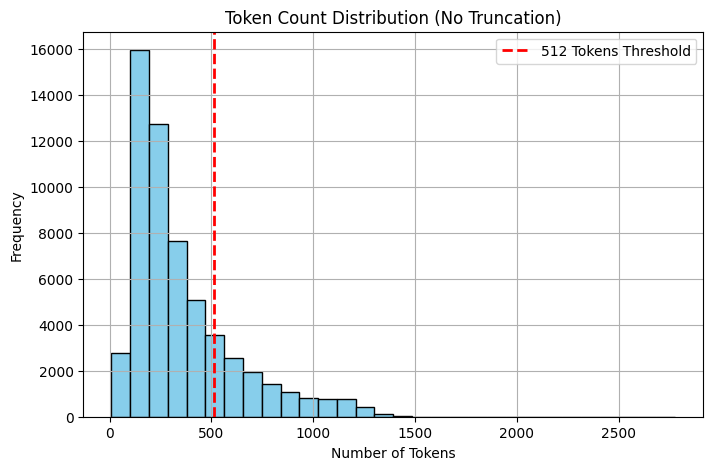

Number of entries exceeding 512 tokens: 11703


In [14]:
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

model_name = "roberta-base"

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize without truncation to capture full token count
def tokenize_without_truncation(batch):
    return tokenizer(batch["review_text"], padding=False, truncation=False)

# Tokenize the dataset
ds_full_tokens = ds.map(tokenize_without_truncation, batched=True, batch_size=None)

# Calculate token counts
ds_full_tokens = ds_full_tokens.map(lambda x: {"token_count": len(x["input_ids"])})

# Extract token counts for plotting
token_counts = [entry['token_count'] for entry in ds_full_tokens['train']]

# Plotting token distribution
plt.figure(figsize=(8, 5))
plt.hist(token_counts, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=512, color='red', linestyle='--', linewidth=2, label='512 Tokens Threshold')

plt.title('Token Count Distribution (No Truncation)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Display the number of entries exceeding 512 tokens
exceeding_512 = [entry for entry in ds_full_tokens['train'] if entry['token_count'] > 512]
print(f"Number of entries exceeding 512 tokens: {len(exceeding_512)}")

These results indicate that a large number of the reviews exceed the 512-token limit so using RoBERTa or BERT with a 512-token max length is not ideal this task.

-> Many reviews exceed 512 tokens (11,703 entries) so it cuts off important parts of long reviews and this could harm model performance.

We can use:
- Transformer with a Larger Token Limit
- Sliding Windows for Tokenization? -> instead of truncating at 512, process text in overlapping chunks
- Summarization Models Before Classification ( px first, summarize using facebook/bart-large-cnn, then pass the summary to RoBERTa )

# Trying Sliding Window??

In [16]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
# No truncation
# tokens = tokenizer(review_text, truncation=False)
tokens = tokenizer(df_train["review_text"].tolist(), truncation=False)
max_length = 512
# Overlap to maintain context
# this ensures each chunk keeps context from the previous chunk
stride = 256  # (512 / 2)
chunks = [tokens['input_ids'][i: i + max_length] for i in range(0, len(tokens['input_ids']), stride)]

Token indices sequence length is longer than the specified maximum sequence length for this model (1007 > 512). Running this sequence through the model will result in indexing errors


# Skip this for sliding window

In [ ]:
model_name = "roberta-base"
# auto tha allaksei se bert an i grafiki diksi oti to max length einai megalitero apo 512?
# model_name = "bert-base-uncased" or "bert-large-cased"

# tokenizer = AutoModelTokenizerFast.from_pretrained(model_name, do_lower_case=True,truncation=True, padding=True,max_length=512)

# truncation=True ensures that if a text is too long (i.e., exceeds the max_length limit of the model), it gets cut off to fit within that limit.
# Transformer models expect fixed-length inputs (e.g., max_length=512). If different texts have different lengths, we cannot batch them together for efficient processing.

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

def tokenize(batch):
    return tokenizer(batch["review_text"], padding=True, truncation=True,
                     max_length=512) # edo na allaksi???

ds_encoded = ds.map(tokenize, batched=True, batch_size=None)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/57643 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [17]:
token_sizes = [len(l['input_ids']) for l in ds_encoded['train']] + [len(l['input_ids']) for l in ds_encoded['test']]

import matplotlib.pyplot as plt
plt.hist(token_sizes, bins=100)
plt.show()

NameError: name 'ds_encoded' is not defined

# Try this instead ?

In [18]:
token_sizes = [len(input_ids) for input_ids in tokens['input_ids']]

In [20]:
print(f"Total number of original reviews: {len(df_train)}")
print(f"Total number of tokenized chunks: {len(chunks)}")

Total number of original reviews: 57643
Total number of tokenized chunks: 226


The length of chunks is a lot larger of the length of the df_train, that means that each long review is split into multiple segments.

In [22]:
chunk_sizes = [len(chunk) for chunk in chunks]
print(chunk_sizes)

[512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,

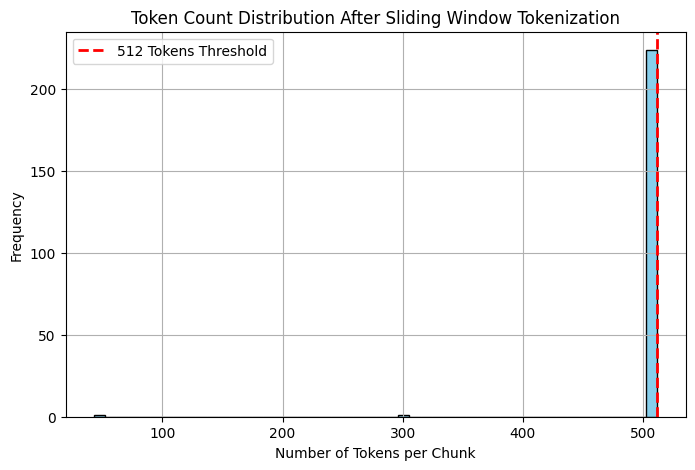

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(chunk_sizes, bins=50, color="skyblue", edgecolor="black")
plt.axvline(x=512, color="red", linestyle="--", linewidth=2, label="512 Tokens Threshold")
plt.title("Token Count Distribution After Sliding Window Tokenization")
plt.xlabel("Number of Tokens per Chunk")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

Now this plot shows that most values are near 512 tokens so it confirms that the sliding window tokenization is working.

Now, we need to ensure that the labels are correctly assigned to each chunk and are converted to tensor format for pytorch.

In [28]:
# We want to create a new dataset from chunks

class SpoilerDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_masks[idx], dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [30]:
num_reviews = len(df_train)
num_chunks = len(chunks)

# Repeat labels correctly
labels = df_train["is_spoiler"].tolist()
expanded_labels = []
for label in labels:
    expanded_labels.extend([label] * (num_chunks // num_reviews))

# Trim excess labels to match chunk count
expanded_labels = expanded_labels[:num_chunks]

In [31]:
# attention masks (1s for all tokens)
attention_masks = [[1] * len(chunk) for chunk in chunks]

# to a PyTorch Dataset
dataset = SpoilerDataset(chunks, attention_masks, expanded_labels)

In [32]:
# renaming it to ds_encoded
ds_encoded = dataset

--------------------------------------------

With sliding window we don't need to do these map steps, we are using a pytorch dataset instead of a hugging face dataset.

In [ ]:
ds_encoded = ds_encoded.map(lambda x: {"labels": int(x["is_spoiler"])})

Map:   0%|          | 0/57643 [00:00<?, ? examples/s]

Map:   0%|          | 0/14411 [00:00<?, ? examples/s]

In [ ]:
# Convert labels to tensor-compatible format
ds_encoded = ds_encoded.map(lambda x: {"labels": torch.tensor(x["labels"], dtype=torch.long)})

Map:   0%|          | 0/57643 [00:00<?, ? examples/s]

Map:   0%|          | 0/14411 [00:00<?, ? examples/s]

In [ ]:
print(ds_encoded["train"].column_names)

['review_text', 'is_spoiler', '__index_level_0__', 'input_ids', 'attention_mask', 'labels']


In [ ]:
print(ds_encoded["train"][0])

{'review_text': 'OK, this Movies isn\'t as bad as its reputation.The thing for me is, it\'s not a Godzilla movie. It may be a decent monster movie, but not a Godzilla movie. It misses VERY IMPORTANT trademarks.E.g. the monster doesn\'t really breath atomic fire. Where are the Stegosaurus spikes? The worst thing is that it\'s getting killed by the military. That never happened in any of the movies before. Godzilla is pretty much immortal. Only another Monster has a chance against Godzilla.It\'s not a complaint about the plot or the CG-effects in General. This movie just does not have the Godzilla feeling. The 2014 version did a way better job.If the movie wasn\'t "Godzilla in the name only" it would have been decent.', 'is_spoiler': True, '__index_level_0__': 46044, 'input_ids': [0, 9335, 6, 42, 27568, 965, 75, 25, 1099, 25, 63, 5070, 4, 133, 631, 13, 162, 16, 6, 24, 18, 45, 10, 43584, 1569, 4, 85, 189, 28, 10, 7297, 13317, 1569, 6, 53, 45, 10, 43584, 1569, 4, 85, 16857, 39789, 28922, 1

In [ ]:
import matplotlib.pyplot as plt

# Extract token counts from 'input_ids'
ds_encoded['train'] = ds_encoded['train'].map(lambda x: {"token_count": len(x["input_ids"])})

# Collect token counts
token_counts = [entry['token_count'] for entry in ds_encoded['train']]

# Plotting
plt.figure(figsize=(8, 5))
plt.hist(token_counts, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=512, color='red', linestyle='--', linewidth=2, label='512 Tokens Threshold')

plt.title('Token Count Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Display entries exceeding 512 tokens
exceeding_512 = [entry for entry in ds_encoded['train'] if entry['token_count'] > 512]
print(f"Number of entries exceeding 512 tokens: {len(exceeding_512)}")

-----------------------------------------------------------------------------

In [45]:
# PREPEI NA GINEI ME DATASET TOU HUGGING FACE H NA MEINEI ME PYTORCH?

# Before defining the model we should prepare a dataloader

from transformers import DataCollatorWithPadding

# Create a data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Create the DataLoaders with padding
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=data_collator)

In [46]:
import os
from transformers import AutoModelForSequenceClassification, AutoConfig

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

config = AutoConfig.from_pretrained(
    model_name,
    output_hidden_states = False,
    num_labels           = len(set(list(y_train) + list(y_test))),
    label2id             = label2id,
    id2label             = id2label
)

In [47]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

batch_size                  = 2
gradient_accumulation_steps = 4

# logging_steps = len(ds_encoded["train"]) // (batch_size * gradient_accumulation_steps)
logging_steps = len(ds_encoded) // (batch_size * gradient_accumulation_steps)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
# Define the output directory where the model will be saved
OUTPUT_DIR = "./"  # You can change this to any valid directory

# Create the directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [49]:
training_args = TrainingArguments(
    output_dir             = os.path.join(OUTPUT_DIR, 'roberta-model'),
    weight_decay           = 0.02,
    learning_rate          = 2e-5,
    evaluation_strategy    = "epoch",
    save_strategy          = 'epoch',
    num_train_epochs       = 2,
    logging_steps          = logging_steps,
    load_best_model_at_end = True,
    save_total_limit       = 2,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size  = batch_size,
    gradient_accumulation_steps = gradient_accumulation_steps
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [50]:
from torch.utils.data import random_split

# Define split ratio (e.g., 80% training, 20% validation)
train_size = int(0.8 * len(ds_encoded))
val_size = len(ds_encoded) - train_size

# Split dataset
train_dataset, val_dataset = random_split(ds_encoded, [train_size, val_size])

In [51]:
def model_init(): return AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)
model.to(device)

trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_dataset,
    eval_dataset    = val_dataset,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience = 2)],

    ###############################################
    # model_init      = model_init                #
    # model           = model                     #
    # compute_metrics = compute_metrics           #
    #                                             #
    # optimizers      = (optimizer, lr_scheduler) #
    ###############################################
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: expected sequence of length 96 at dim 1 (got 300)

In [ ]:
model = trainer.model

model.save_pretrained(os.path.join(OUTPUT_DIR, 'roberta-model/pretrained'), save_config=True)

trainer.evaluate(ds_encoded["validation"])

preds_output = trainer.predict(ds_encoded["validation"])

y_preds = np.argmax(preds_output.predictions, axis=1)

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2714: UserWarning: `save_config` is deprecated and will be removed in v5 of Transformers. Use `is_main_process` instead.
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

print(f"F1 Score : {f1_score(y_test, y_preds)}")
print(f"Accuracy : {accuracy_score(y_test, y_preds)}")
print(f"Precision: {precision_score(y_test, y_preds)}")
print(f"Recall   : {recall_score(y_test, y_preds)}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_preds)}")

print(classification_report(y_test, y_preds))


F1 Score : 0.6886171213546566
Accuracy : 0.689784442361762
Precision: 0.6892655367231638
Recall   : 0.6879699248120301
ROC AUC  : 0.6897793549293797
              precision    recall  f1-score   support

       False       0.69      0.69      0.69       535
        True       0.69      0.69      0.69       532

    accuracy                           0.69      1067
   macro avg       0.69      0.69      0.69      1067
weighted avg       0.69      0.69      0.69      1067

